# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 314757212
~~~

~~~
STUDENT GIT LINK: https://github.com/NatanLishinskyFischer/52025
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2024_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [ ]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, RepeatVector, Dense

config = {
    "training_size": 50000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "epochs": 50
}

maxlen = config["digits"] + 1 + config["digits"]
chars = "0123456789+- "
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

def encode(s, num_rows):
    """One-hot encodes a string."""
    x = np.zeros((num_rows, len(chars)))
    for i, c in enumerate(s):
        x[i, char_indices[c]] = 1
    return x

def decode(x):
    """Decodes a one-hot encoded string."""
    return ''.join(indices_char[i] for i in x.argmax(axis=-1))


questions, answers = [], []
seen = set()
while len(questions) < config["training_size"]:
    a = np.random.randint(0, 10**config["digits"])
    b = np.random.randint(0, 10**config["digits"])
    op = np.random.choice(['+', '-'])
    key = (a, b, op)
    if key in seen:
        continue
    seen.add(key)
    query = f"{a}{op}{b}".ljust(maxlen)
    ans = str(a + b if op == '+' else a - b)
    ans = ans[:config["digits"]].ljust(config["digits"] + 1)
    questions.append(query)
    answers.append(ans)

x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool_)
y = np.zeros((len(answers), config["digits"] + 1, len(chars)), dtype=np.bool_)
for i, q in enumerate(questions):
    x[i] = encode(q, maxlen)
for i, a in enumerate(answers):
    y[i] = encode(a, config["digits"] + 1)

indices = np.arange(len(y))
np.random.shuffle(indices)
x, y = x[indices], y[indices]

split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

model = Sequential([
    LSTM(config["hidden_size"], input_shape=(maxlen, len(chars))),
    RepeatVector(config["digits"] + 1),
    LSTM(config["hidden_size"], return_sequences=True),
    TimeDistributed(Dense(len(chars), activation='softmax'))
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

digit_correct_count = np.zeros(config["digits"] + 1)
digit_total_count = np.zeros(config["digits"] + 1)

for epoch in range(config["epochs"]):
    print(f"Epoch {epoch+1}/{config['epochs']}")
    model.fit(x_train, y_train, batch_size=config["batch_size"], epochs=1, validation_data=(x_val, y_val))

    for _ in range(5):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict(rowx)
        guess = decode(preds[0])
        q = decode(rowx[0])
        correct = decode(rowy[0])
        print(f"Q: {q} T: {correct} Pred: {guess}")

        for i in range(len(correct)):
            if i < len(guess):
                digit_total_count[i] += 1
                if guess[i] == correct[i]:
                    digit_correct_count[i] += 1

print("\nDigit-wise Accuracy:")
for i in range(config["digits"] + 1):
    accuracy = (digit_correct_count[i] / digit_total_count[i]) * 100 if digit_total_count[i] > 0 else 0
    print(f"Digit {i+1}: {accuracy:.2f}% correct")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 5, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 5, 13)               │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,965 (804.55 KB)

 Trainable params: 205,965 (804.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2904 - loss: 2.0147 - val_accuracy: 0.3685 - val_loss: 1.7147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Q: 1267+5987 T: 7254  Pred: 1003 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Q: 8486+1511 T: 9997  Pred: 1063 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Q: 7190-5797 T: 1393  Pred: -106 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Q: 4815+547  T: 5362  Pred: 1066 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Q: 6782+3936 T: 1071  Pred: 1163 
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3694 - loss: 1.6950 - val_accuracy: 0.3746 - val_loss: 1.6487
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Q: 9168-1238 T: 7930  Pred: 3266 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Q: 5469+7161 T: 1263  Pred: 1226 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Q: 4314-996  T: 3318  Pred: -375 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Q: 9483+4870 T: 1435  Pred: 1166 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Q: 5101+8611 T: 1371  Pred: 1226 
Epoch 3/50
352/352 ━━━━

1.2).

a) Do you think this model performs well?  Why or why not?

This model performs quite bad... I works preety good for the 1st digit, but as we go further, the accuracy gets worse.

b) What are its limitations?

There are several limitations to this model. To name a few, it is trained on a fixed length data, simple random arithmetic problems, limited output length.

c) What would you do to improve it?    

We could use a transformer that could handle long range dependencies. We could also use an error correction mechanism that will be used as a regulization.

d) Can you apply an attention mechanism to this model? Why or why not?

Yes, we can apply an attantion mechanis, which will enable better focus on relevant input parts. However it won't be necessary. Since the input includes 9 characters at most (4 digits + operation + 4 digits) the LSTM may already capture enough context without the use for attention.

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, TimeDistributed, RepeatVector, Activation, Dot, Concatenate


config = {
    "training_size": 50000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "epochs": 50
}

maxlen = config["digits"] + 1 + config["digits"]
chars = "0123456789+- "
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

def encode(s, num_rows):
    """One-hot encodes a string."""
    x = np.zeros((num_rows, len(chars)))
    for i, c in enumerate(s):
        x[i, char_indices[c]] = 1
    return x

def decode(x):
    """Decodes a one-hot encoded string."""
    return ''.join(indices_char[i] for i in x.argmax(axis=-1))


questions, answers = [], []
seen = set()
while len(questions) < config["training_size"]:
    a = np.random.randint(0, 10**config["digits"])
    b = np.random.randint(0, 10**config["digits"])
    op = np.random.choice(['+', '-'])
    key = (a, b, op)
    if key in seen:
        continue
    seen.add(key)
    query = f"{a}{op}{b}".ljust(maxlen)
    ans = str(a + b if op == '+' else a - b)
    ans = ans[:config["digits"]].ljust(config["digits"] + 1)
    questions.append(query)
    answers.append(ans)


x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool_)
y = np.zeros((len(answers), config["digits"] + 1, len(chars)), dtype=np.bool_)
for i, q in enumerate(questions):
    x[i] = encode(q, maxlen)
for i, a in enumerate(answers):
    y[i] = encode(a, config["digits"] + 1)


indices = np.arange(len(y))
np.random.shuffle(indices)
x, y = x[indices], y[indices]


split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

# Here I added the attention mechanism
def attention_layer(hidden_states, decoder_state):
    score = Dot(axes=[2, 2])([hidden_states, decoder_state])
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[1, 1])([attention_weights, hidden_states])
    return context_vector


encoder_inputs = Input(shape=(maxlen, len(chars)))
encoder_lstm = LSTM(config["hidden_size"], return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

decoder_inputs = RepeatVector(config["digits"] + 1)(state_h)
decoder_lstm = LSTM(config["hidden_size"], return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

context_vector = attention_layer(encoder_outputs, decoder_outputs)
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])
output_layer = TimeDistributed(Dense(len(chars), activation='softmax'))
outputs = output_layer(decoder_combined_context)

model = Model(encoder_inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

correct_digits = np.zeros(config["digits"] + 1)
total_digits = np.zeros(config["digits"] + 1)

for epoch in range(config["epochs"]):
    print(f"Epoch {epoch+1}/{config['epochs']}")
    model.fit(x_train, y_train, batch_size=config["batch_size"], epochs=1, validation_data=(x_val, y_val))

for _ in range(5):
    ind = np.random.randint(0, len(x_val))
    rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
    preds = model.predict(rowx)
    guess = decode(preds[0])
    q = decode(rowx[0])
    correct = decode(rowy[0])

    print(f"Q: {q} T: {correct} Pred: {guess}")

    for i in range(len(correct.strip())):
        if i < len(guess.strip()) and correct[i] == guess[i]:
            correct_digits[i] += 1
        total_digits[i] += 1

digit_accuracies = [(correct_digits[i] / total_digits[i]) * 100 if total_digits[i] > 0 else 0 for i in range(config["digits"] + 1)]
print(f"Final Digit-wise accuracy: {digit_accuracies}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 9, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 9, 128),       │         72,704 │ input_layer_2[0][0]    │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 5, 128)         │              0 │ lstm_4[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 5, 128)         │        131,584 │ repeat_vector_2[0][0], │
│                           │                        │                │ lstm_4[0][1],          │
│                           │                        │                │ lstm_4[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 9, 5)           │              0 │ lstm_4[0][0],          │
│                           │                        │                │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 9, 5)           │              0 │ dot[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_1 (Dot)               │ (None, 5, 128)         │              0 │ activation[0][0],      │
│                           │                        │                │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 5, 256)         │              0 │ dot_1[0][0],           │
│                           │                        │                │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 5, 13)          │          3,341 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 207,629 (811.05 KB)

 Trainable params: 207,629 (811.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3209 - loss: 1.9390 - val_accuracy: 0.3666 - val_loss: 1.6901
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3718 - loss: 1.6766 - val_accuracy: 0.3850 - val_loss: 1.6384
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3926 - loss: 1.6140 - val_accuracy: 0.4176 - val_loss: 1.5511
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4239 - loss: 1.5308 - val_accuracy: 0.4355 - val_loss: 1.4818
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4515 - loss: 1.4528 - val_accuracy: 0.4584 - val_loss: 1.4204
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4753 - loss: 1.3913 - val_accuracy: 0.4848 - val_loss: 1.3593
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4873 - loss: 1.3556 - val_accuracy: 0.4753 - val_loss: 1.3576
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4933 - loss: 1.3309 - val_accuracy: 0

The addition of an attention mechanism improved a little all other digits showed worse results.

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, TimeDistributed, RepeatVector, Activation, Dot, Concatenate, Bidirectional, LayerNormalization, Dropout, MultiHeadAttention

# Updated Config
config = {
    "training_size": 100000,  # Increased dataset
    "digits": 4,
    "hidden_size": 256,  # Increased model capacity
    "batch_size": 128,
    "epochs": 50,
}

maxlen = config["digits"] + 1 + config["digits"]
chars = "0123456789+- "
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

def encode(s, num_rows):
    """One-hot encodes a string."""
    x = np.zeros((num_rows, len(chars)))
    for i, c in enumerate(s):
        x[i, char_indices[c]] = 1
    return x

def decode(x):
    """Decodes a one-hot encoded string."""
    return ''.join(indices_char[i] for i in x.argmax(axis=-1))

# Data Preparation (Same logic but larger dataset)
questions, answers = [], []
seen = set()
while len(questions) < config["training_size"]:
    a = np.random.randint(0, 10**config["digits"])
    b = np.random.randint(0, 10**config["digits"])
    op = np.random.choice(['+', '-'])
    key = (a, b, op)
    if key in seen:
        continue
    seen.add(key)
    query = f"{a}{op}{b}".ljust(maxlen)
    ans = str(a + b if op == '+' else a - b)
    ans = ans[:config["digits"]].ljust(config["digits"] + 1)
    questions.append(query)
    answers.append(ans)

x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool_)
y = np.zeros((len(answers), config["digits"] + 1, len(chars)), dtype=np.bool_)
for i, q in enumerate(questions):
    x[i] = encode(q, maxlen)
for i, a in enumerate(answers):
    y[i] = encode(a, config["digits"] + 1)

indices = np.arange(len(y))
np.random.shuffle(indices)
x, y = x[indices], y[indices]

split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

# Transformer-based Attention Layer
def transformer_attention_layer(hidden_states, decoder_state):
    """Uses multi-head attention for better feature extraction."""
    attention_output = MultiHeadAttention(num_heads=4, key_dim=config["hidden_size"] // 4)(decoder_state, hidden_states)
    attention_output = LayerNormalization()(attention_output)
    return attention_output

# Model Architecture
encoder_inputs = Input(shape=(maxlen, len(chars)))
encoder_lstm = Bidirectional(LSTM(config["hidden_size"], return_sequences=True, return_state=True, dropout=0.3))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)

# Concatenating forward and backward states
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

decoder_inputs = RepeatVector(config["digits"] + 1)(state_h)
decoder_lstm = LSTM(config["hidden_size"] * 2, return_sequences=True, dropout=0.3)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

context_vector = transformer_attention_layer(encoder_outputs, decoder_outputs)
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])
decoder_combined_context = Dropout(0.3)(decoder_combined_context)

output_layer = TimeDistributed(Dense(len(chars), activation='softmax'))
outputs = output_layer(decoder_combined_context)

# Model Compilation
model = Model(encoder_inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Training
for epoch in range(config["epochs"]):
    print(f"Epoch {epoch+1}/{config['epochs']}")
    model.fit(x_train, y_train, batch_size=config["batch_size"], epochs=1, validation_data=(x_val, y_val))

# Evaluation
correct_digits = np.zeros(config["digits"] + 1)
total_digits = np.zeros(config["digits"] + 1)

for _ in range(5):
    ind = np.random.randint(0, len(x_val))
    rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
    preds = model.predict(rowx)
    guess = decode(preds[0])
    q = decode(rowx[0])
    correct = decode(rowy[0])

    print(f"Q: {q} T: {correct} Pred: {guess}")

    for i in range(len(correct.strip())):
        if i < len(guess.strip()) and correct[i] == guess[i]:
            correct_digits[i] += 1
        total_digits[i] += 1

digit_accuracies = [(correct_digits[i] / total_digits[i]) * 100 if total_digits[i] > 0 else 0 for i in range(config["digits"] + 1)]
print(f"Final Digit-wise accuracy: {digit_accuracies}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9, 13)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ [(None, 9, 512),       │        552,960 │ input_layer[0][0]      │
│ (Bidirectional)           │ (None, 256), (None,    │                │                        │
│                           │ 256), (None, 256),     │                │                        │
│                           │ (None, 256)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ bidirectional[0][1],   │
│                           │                        │                │ bidirectional[0][3]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 5, 512)         │              0 │ concatenate[0][0]      │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 512)            │              0 │ bidirectional[0][2],   │
│ (Concatenate)             │                        │                │ bidirectional[0][4]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 5, 512)         │      2,099,200 │ repeat_vector[0][0],   │
│                           │                        │                │ concatenate[0][0],     │
│                           │                        │                │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 5, 512)         │        525,568 │ lstm_1[0][0],          │
│ (MultiHeadAttention)      │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 5, 512)         │          1,024 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 5, 1024)        │              0 │ layer_normalization[0… │
│ (Concatenate)             │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 5, 1024)        │              0 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 5, 13)          │         13,325 │ dropout_1[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,192,077 (12.18 MB)

 Trainable params: 3,192,077 (12.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.3505 - loss: 1.8217 - val_accuracy: 0.3758 - val_loss: 1.6748
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.3837 - loss: 1.6505 - val_accuracy: 0.4085 - val_loss: 1.5848
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.4101 - loss: 1.5741 - val_accuracy: 0.4377 - val_loss: 1.5290
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.4454 - loss: 1.4866 - val_accuracy: 0.4911 - val_loss: 1.3686
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.4967 - loss: 1.3461 - val_accuracy: 0.5304 - val_loss: 1.2669
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5427 - loss: 1.2328 - val_accuracy: 0.5671 - val_loss: 1.1666
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5777 - loss: 1.1376 - val_accuracy: 0.6007 - val_loss: 1.0834
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6069 - loss: 1.0703 - 

In this model I made some changes, particularly added bidirectional encoder and transformer based attention. I hoped that this would enhance the model performance and will be more effective. This is true for the first digit, but the 2nd and 3rd digit were worse. The 4th digit was actually better.

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

In [ ]:
hebrew_sentences = []
english_sentences = []

with open('heb.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t', maxsplit=2)
        if len(parts) == 3:  # Ensure we have exactly two elements
            eng, heb = parts[0], parts[1]
            english_sentences.append(eng)
            hebrew_sentences.append(heb)
        else:
            print(f"Skipping malformed line: {line.strip()}")


In [1]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    fig, ax = plt.subplots()  # Create a figure and an axis
    loc = ticker.MultipleLocator(base=0.2)  # Set the tick locator for y-axis
    ax.yaxis.set_major_locator(loc)  # Apply the locator to the y-axis
    ax.plot(points)  # Plot the points

    plt.show()  # Ensure the plot is displayed


# losses = [1.797294017754189,
#  0.9822397633162264,
#  0.5931101046604652,
#  0.35207395360690275,
#  0.20569399875933175,
#  0.1244558680598458,
#  0.08218583233195216,
#  0.06204252054481065,
#  0.04862272276045525,
#  0.04140926151191944,
#  0.03654120714939518,
#  0.03330748239627797,
#  0.03103531482182953,
#  0.028938293978508105,
#  0.02672026161557344,
#  0.026226580170723168]
#showPlot(losses)

SOLUTION:

Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
fra 7519
eng 3067
['היא לא טועה.', 'she is not wrong']
Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
fra 7519
eng 3067
0m 34s (- 8m 33s) (5 6%) 1.7751
1m 7s (- 7m 52s) (10 12%) 0.9595
1m 38s (- 7m 8s) (15 18%) 0.5829
2m 11s (- 6m 33s) (20 25%) 0.3499
2m 43s (- 5m 58s) (25 31%) 0.2080
3m 14s (- 5m 23s) (30 37%) 0.1284
3m 46s (- 4m 51s) (35 43%) 0.0855
4m 17s (- 4m 17s) (40 50%) 0.0634
4m 49s (- 3m 45s) (45 56%) 0.0496
5m 21s (- 3m 12s) (50 62%) 0.0424
5m 52s (- 2m 40s) (55 68%) 0.0371
6m 24s (- 2m 8s) (60 75%) 0.0343
6m 55s (- 1m 35s) (65 81%) 0.0310
7m 27s (- 1m 3s) (70 87%) 0.0289
7m 58s (- 0m 31s) (75 93%) 0.0270
8m 29s (- 0m 0s) (80 100%) 0.0265


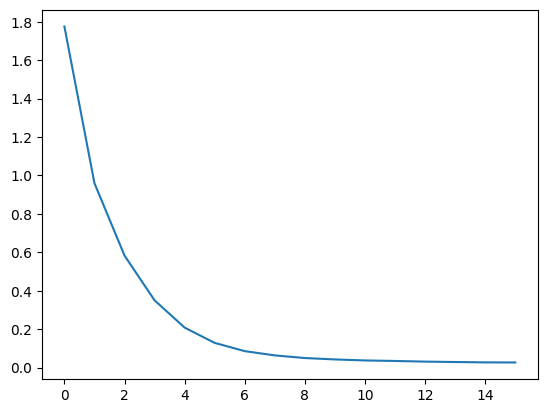

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('heb.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    # Split every line into pairs and normalize
    pairs = [[s for s in l.split('\t')[:2]] for l in lines]
    pairs = [[normalizeString(s), t] for s,t in pairs]    # Reverse pairs, make Lang instances

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader


def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=5):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    return plot_losses


hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

losses = train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [3]:
import torch
import random

# Assuming these functions and variables are defined elsewhere
# EOS_token, tensorFromSentence, input_lang, output_lang, pairs

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluate_with_accuracy(encoder, decoder, sentence, target_sentence, input_lang, output_lang):
    output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
    output_sentence = ' '.join(output_words)

    # Calculate accuracy
    target_words = target_sentence.split(' ')  # Assuming target_sentence is a string
    correct = sum(1 for word1, word2 in zip(output_words, target_words) if word1 == word2)
    accuracy = correct / len(target_words) if target_words else 0  # Avoid division by zero

    return output_sentence, accuracy

def evaluateRandomly(encoder, decoder, n=20):
    total_accuracy = 0
    for i in range(n):
        pair = random.choice(pairs)
        input_sentence, target_sentence = pair[0], pair[1]

        print('>', input_sentence)
        print('=', target_sentence)

        output_sentence, accuracy = evaluate_with_accuracy(encoder, decoder, input_sentence, target_sentence, input_lang, output_lang)

        print('<', output_sentence)
        print(f'Accuracy: {accuracy:.4f}')
        print('')

        total_accuracy += accuracy

    avg_accuracy = total_accuracy / n
    print(f'Average accuracy: {avg_accuracy:.4f}')

evaluateRandomly(encoder, decoder)


> הוא היה די מרוצה מההכנסה שלו.
= he is quite satisfied with his income
< we re quite satisfied with his income <EOS>
Accuracy: 0.7143

> אני מתעניין בהיסטוריה.
= i m interested in history
< i m interested in history <EOS>
Accuracy: 1.0000

> אני מחבבת אותך מאד.
= i m very fond of you
< you re very fond of you <EOS>
Accuracy: 0.6667

> אני לא עומד להיות מעורה בזה.
= i am not getting involved
< we re not making good any second <EOS>
Accuracy: 0.2000

> ניתן לסמוך עלי.
= i m trustworthy
< i m trustworthy <EOS>
Accuracy: 1.0000

> אינך משתף פעולה.
= you aren t cooperating
< you aren t cooperating <EOS>
Accuracy: 1.0000

> הוא לא בטוח שהוא מוכן.
= he s not sure he s ready
< he s not sure he s ready <EOS>
Accuracy: 1.0000

> אזל לכם הסוכר.
= you re out of sugar
< you re out of sugar <EOS>
Accuracy: 1.0000

> אני תקועה פה בבוסטון.
= i m stuck here in boston
< i m stuck here in boston <EOS>
Accuracy: 1.0000

> אתה כשרוני.
= you re talented
< you re talented <EOS>
Accuracy: 1.0000

> אני חושש 

Input: אני עושה לך טובה.
Predicted: i m doing you a favor of you
Target: i m doing you a favor



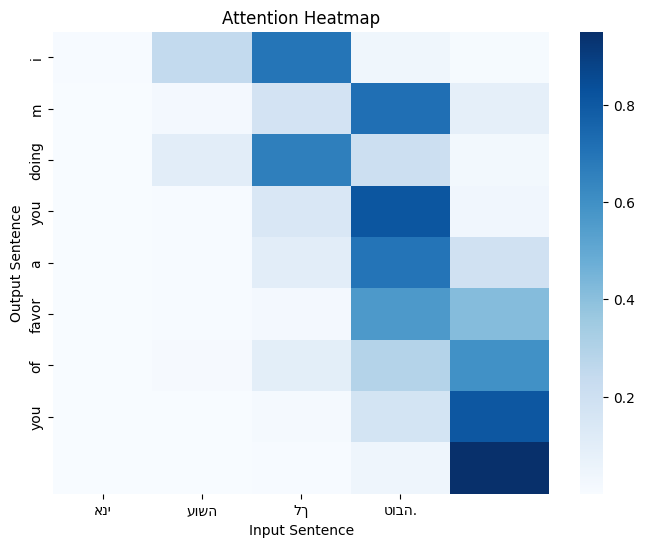

Input: הוא אף פעם לא מרוצה.
Predicted: we re not satisfied
Target: he s never satisfied



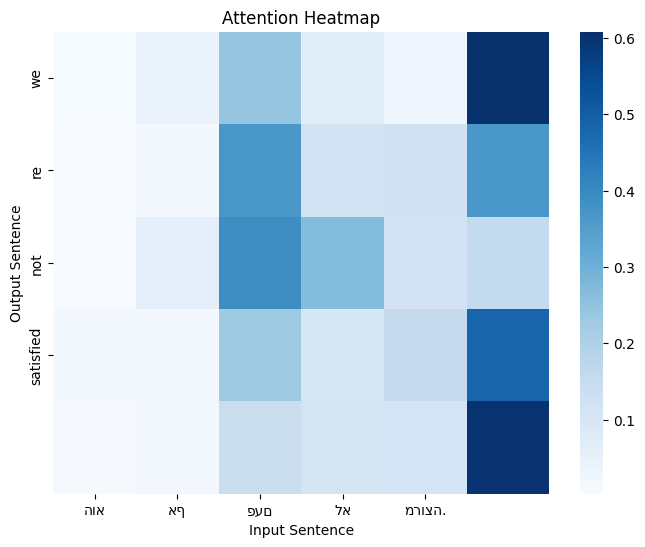

Input: אני חושב על עזיבה.
Predicted: i m thinking about leaving
Target: i m thinking about leaving



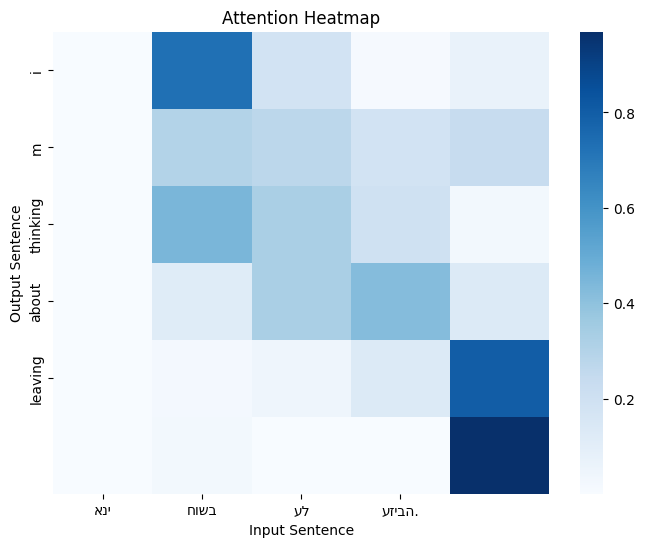

Input: אני אמור לדבר איתך.
Predicted: i m supposed to talk to you
Target: i m supposed to talk to you



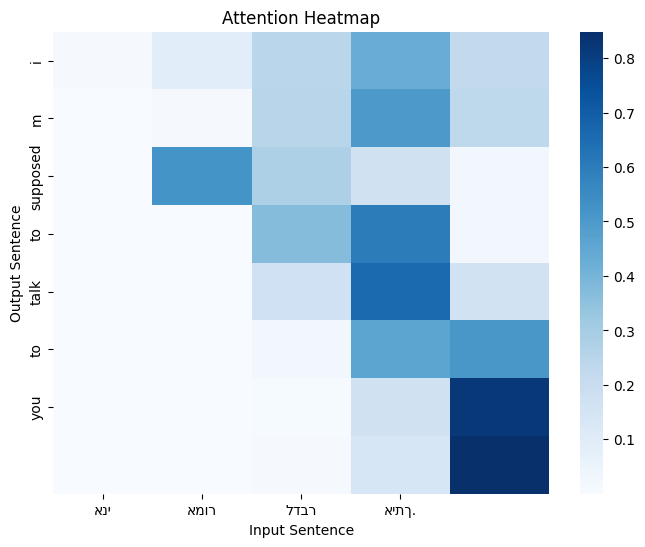

Input: אני רדומה מאד עכשיו.
Predicted: i m very sleepy now now
Target: i m very sleepy now



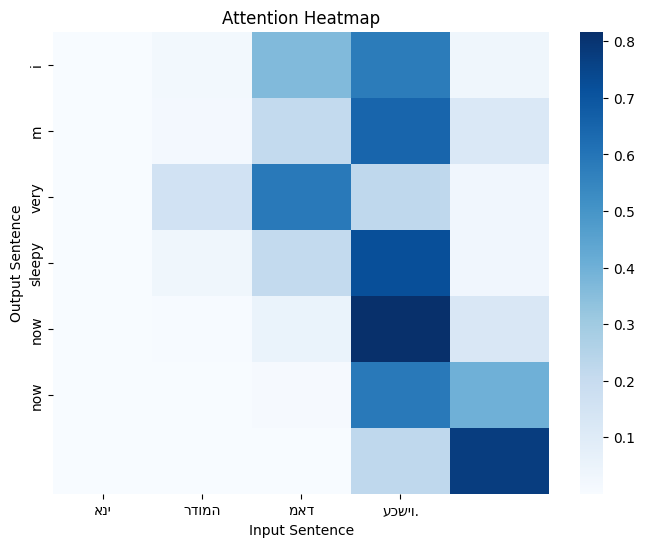

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

def show_attention(input_sentence, output_sentence, attention_weights):
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.heatmap(attention_weights.squeeze(0).cpu().detach().numpy(),
                xticklabels=input_sentence.split(' '),
                yticklabels=output_sentence.split(' '),
                cmap='Blues', ax=ax)

    ax.set_xlabel("Input Sentence")
    ax.set_ylabel("Output Sentence")
    ax.set_title("Attention Heatmap")
    plt.show()


def evaluate(encoder, decoder, sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        attentions = []

        for _ in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = decoder.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            attentions.append(attn_weights.squeeze(1))

            _, topi = decoder_output.topk(1)
            if topi.item() == EOS_token:
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                decoder_input = topi.squeeze(-1).detach().view(1, -1)

        return ' '.join(decoded_words), torch.cat(attentions, dim=0)

# Select 5 random sentences
random_sentences = random.sample(pairs, 5)

for pair in random_sentences:
    input_sentence = pair[0]
    target_sentence = pair[1]
    output_sentence, attention_weights = evaluate(encoder, decoder, input_sentence)
    print(f'Input: {input_sentence}')
    print(f'Predicted: {output_sentence}')
    print(f'Target: {target_sentence}\n')
    show_attention(input_sentence, output_sentence, attention_weights)


Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
fra 7519
eng 3067
['אתה אשם.', 'you re to blame']
Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
fra 7519
eng 3067
0m 34s (- 8m 36s) (5 6%) 1.6793
1m 8s (- 8m 1s) (10 12%) 0.8117
1m 42s (- 7m 23s) (15 18%) 0.4383
2m 16s (- 6m 50s) (20 25%) 0.2389
2m 51s (- 6m 16s) (25 31%) 0.1415
3m 24s (- 5m 41s) (30 37%) 0.0963
3m 59s (- 5m 7s) (35 43%) 0.0706
4m 33s (- 4m 33s) (40 50%) 0.0569
5m 7s (- 3m 58s) (45 56%) 0.0481
5m 41s (- 3m 24s) (50 62%) 0.0423
6m 15s (- 2m 50s) (55 68%) 0.0369
6m 49s (- 2m 16s) (60 75%) 0.0347
7m 23s (- 1m 42s) (65 81%) 0.0321
7m 57s (- 1m 8s) (70 87%) 0.0307
8m 32s (- 0m 34s) (75 93%) 0.0287
9m 5s (- 0m 0s) (80 100%) 0.0277


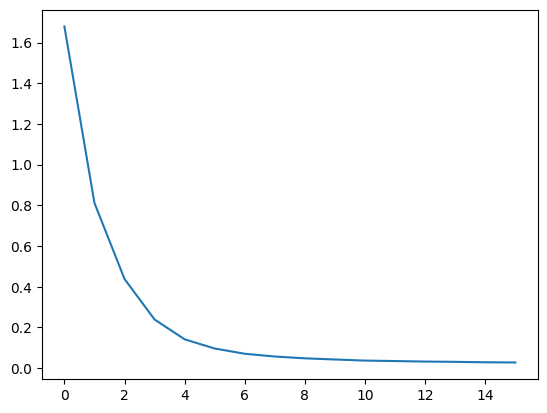

In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('heb.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    # Split every line into pairs and normalize
    pairs = [[s for s in l.split('\t')[:2]] for l in lines]
    pairs = [[normalizeString(s), t] for s,t in pairs]    # Reverse pairs, make Lang instances

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)  # Add layer normalization
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        output = self.layer_norm(output)  # Apply layer normalization
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader


def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=5):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    return plot_losses


hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

losses = train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [7]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

evaluateRandomly(encoder, decoder)

> אתם אדירים.
= you re awesome
< you re awesome <EOS>

> אני חלשה.
= i am weak
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> אני מחכה לראות איך יתפתחו העניינים.
= i m waiting to see how things will develop
< i m trying to impress things develop <EOS>

> אני רק השליח.
= i m just the messenger
< i m the messenger <EOS>

> אתה טרחן אמיתי.
= you re a real pain
< you re a real pain <EOS>

> זה הניהול שלך.
= you re the boss
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> את בסכנה כאן.
= you re in danger here
< here as here <EOS>

> אני שמחה לפגוש אותך כאן.
= i m glad to see you here
< i m pleased to see you here <EOS>

> אתה תופר טוב מאוד.
= you re very good at sewing
< we re very good dinner <EOS>

> אני עסוק כרגע, טום.
= i m busy right now tom
< i m busy right tom tom <EOS>

> התמזל מזלך.
= you re in luck
< you re in luck <EOS>

> אני מרוצה שהבהרנו את הנושא הזה.
= i m glad we cleared that up
< i m glad we cleared that we won <EOS>

> אתה מפחיד את טום.
= you re scaring tom
< we re tom tom <EOS>

In [8]:
import torch
import random

# Assuming these functions and variables are defined elsewhere
# EOS_token, tensorFromSentence, input_lang, output_lang, pairs

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluate_with_accuracy(encoder, decoder, sentence, target_sentence, input_lang, output_lang):
    output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
    output_sentence = ' '.join(output_words)

    # Calculate accuracy
    target_words = target_sentence.split(' ')  # Assuming target_sentence is a string
    correct = sum(1 for word1, word2 in zip(output_words, target_words) if word1 == word2)
    accuracy = correct / len(target_words) if target_words else 0  # Avoid division by zero

    return output_sentence, accuracy

def evaluateRandomly(encoder, decoder, n=20):
    total_accuracy = 0
    for i in range(n):
        pair = random.choice(pairs)
        input_sentence, target_sentence = pair[0], pair[1]

        print('>', input_sentence)
        print('=', target_sentence)

        output_sentence, accuracy = evaluate_with_accuracy(encoder, decoder, input_sentence, target_sentence, input_lang, output_lang)

        print('<', output_sentence)
        print(f'Accuracy: {accuracy:.4f}')
        print('')

        total_accuracy += accuracy

    avg_accuracy = total_accuracy / n
    print(f'Average accuracy: {avg_accuracy:.4f}')

evaluateRandomly(encoder, decoder)


> אתה לא חולה.
= you re not sick
< you re not sick <EOS>
Accuracy: 1.0000

> אני בא.
= i am coming
< i am coming <EOS>
Accuracy: 1.0000

> היא מעניינת, אבל מדברת יותר מדי.
= she is attractive but she talks too much
< she is attractive but she talks too much <EOS>
Accuracy: 1.0000

> אני אלך.
= i m going to go
< i m going to go <EOS>
Accuracy: 1.0000

> אנו מוכנים להיפגש ולדון על התנאים שלך.
= we re prepared to meet to discuss your terms
< we re prepared to meet to discuss your terms <EOS>
Accuracy: 1.0000

> הם למטה.
= they re downstairs
< they re downstairs <EOS>
Accuracy: 1.0000

> הוא חמוש מכף רגל עד ראש.
= he is armed to the teeth
< he is armed to the teeth <EOS>
Accuracy: 1.0000

> אני בטוחה שתצליח מצויין.
= i m sure you ll do great
< i m back to do great <EOS>
Accuracy: 0.2857

> אנו תמיד נזהרים.
= we re always careful
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
Accuracy: 0.0000

> אנו שפני ניסוי.
= we re test subjects
< we re guinea pigs <EOS>
Accuracy: 0.5000

> הם מוגנים.
= they

In the model above I added layer normalization. I thought that this addition would benifit with stabilizing training and generalization. However, I was surprised to find out that the average accuracy was 0.76 compared to 0.81 in the previous approach.